# Study realize_lcs with selection of observtions

Look at how realize_lcs behaves when we select observations from a observations table, such that a SN is only observed within 
a phase window of its maximum light

In [1]:
import sncosmo
import simulate_lsst as sl
import numpy as np
from numpy.random import normal, uniform
from astropy.table import Table
%matplotlib inline
import pandas as pd

In [2]:
print "sncosmo version : ", sncosmo.__version__

sncosmo version :  1.1.dev46


### Boilerplate

The basis of the simulation is a "SIMLIB" file which is a list of observations in a particular field of the sky. This simlib file is therefore created from either the OPSIMs output (which is a database of observations made over the course of the survey) or from OpsimObs (which is a time ordered set of observations) made across the survey for Deep Drilling fields for a particular strategy.

I have included code for going from OpsimObs output to simlib file, but 
we decided to actually use Opsim ouputs. This still needs work on my (Rahul) part, and so we will use a simlib file right away

num SN generated  578
realizing SN
num SN generated  364
realizing SN


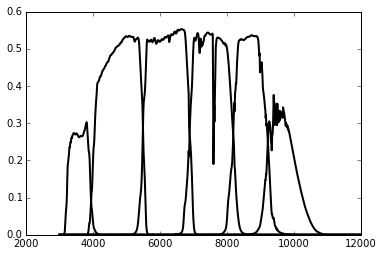

In [3]:
simlibfilename = 'cache/RBtest_opsim.simlib'
lcs = sl.simulate_simlib(simlibfilename, snmodelsource='salt2-extended', outfile='LC/lcs')
# set up bandpasses for LSST
sl.getlsstbandpassobjs(plot=True)

In [4]:
lc = lcs[0][0]
bandgroups = lc.group_by('band')

In [5]:
import pandas as pd
basicdata = np.asarray(lc)
df = pd.DataFrame(basicdata)

In [6]:
grouped = df.groupby('band')
presentbands = grouped.groups.keys()
print presentbands
bandlcs = []
for band in presentbands:
    bandlcs.append(df.loc[grouped.groups[band]])

['LSST_i', 'LSST_r', 'LSST_g']


In [7]:
type(grouped)

pandas.core.groupby.DataFrameGroupBy

In [8]:
bandgroups.groups[0]['flux']/bandgroups.groups[0]['fluxerr']

<Column name='flux' unit=None format=None description=None>
array([ 0.57411351, -1.01420261, -1.47589816,  0.84074951,  0.57787069,
       -1.11278773, -0.06312925,  1.81065311,  0.37398506,  2.67959685,
        2.47876281,  3.59188674,  2.5997284 ,  2.10861101,  2.93600979,
        4.33615246,  4.5329612 ,  3.19571176,  4.35284874,  4.54402246,
        5.13140513,  4.62550959,  4.05189062,  1.73539201,  3.48822286,
        3.1494571 ,  0.82809907,  0.62224066,  0.1051184 ,  0.67705598,
        1.67109769,  1.8021161 ,  2.76847645,  1.57135871,  3.91246579,
        3.90496869,  2.15749054,  1.64468653,  1.98370013,  1.44250898,
       -1.59772931,  1.43885966,  0.04148623,  0.15815662, -0.10969312,
       -0.65985485,  0.3636706 ,  0.58497161,  0.81289027,  1.44409802,
       -2.10198158, -1.12387755, -0.4084217 , -1.31420893,  0.08671311,
        0.03713375, -1.25206949, -1.07889693,  0.37610355, -0.24421082,
       -0.57527997,  1.32043812,  2.12114942,  2.22227677,  2.47081825,
    

In [9]:
map(lambda xx: max(xx['flux'] / xx['fluxerr']), bandgroups.groups)

[5.1314051291052047, 35.262755485458761, 19.685873192084443]

In [10]:
map(lambda y: y+2, [0.,1.,2.])

[2.0, 3.0, 4.0]

In [11]:
#Read the simlib file, get the libids which index different fields
meta, obstables = sncosmo.read_snana_simlib(simlibfilename)
print "META\n"
print meta
print "\n\n OBSTABLE LIBIDS \n"
print obstables.keys()

META

OrderedDict([('SURVEY', 'LSST'), ('FILTERS', 'ugrizY'), ('TELESCOPE', 'LSST'), ('USER', 'cinabro'), ('HOST', 'motor1'), ('COMMENT', 'LSST \x00\x00\x00\x00'), ('END_OF_SIMLIB', '2 ENTRIES')])


 OBSTABLE LIBIDS 

[519, 1427]


In [12]:
#Choose a field: for example the one indexed by 519
minmjd = obstables[519]['MJD'].min()
maxmjd = obstables[519]['MJD'].max()
obstable = obstables[519]
print "Number of observations in obstable: ", len(obstable)
print "min and max MJD in the set: ", minmjd, maxmjd

Number of observations in obstable:  18279
min and max MJD in the set:  49353.11458 54827.13317


In [13]:
#Set SNCosmo model and set its t0 aritificially to values I know are in the above table
model = sncosmo.Model(source='salt2-extended')
params = []
# For a longer /complete answer, we will not set the z by hand, we will 
# draw from a distribution, but we are just doing one SN. So this is a
# good way
for z in [0.7,0.3]:
    mabs = normal(-19.3, 0.3)
    print 'mabs', mabs
    model.set(z=z)
    model.set_source_peakabsmag(mabs, 'bessellb', 'ab')
    
    # RB: really should not be min, max but done like in catalogs
    p = {'z':z, 't0': uniform(minmjd, maxmjd), 'x1': normal(0., 1.), 'c': normal(0., 0.1)}
    x0 = model.get('x0')
    p['x0']=x0
    p['t0']= 50000.
    params.append(p)
params[1]['t0'] = 50100.
print params[0]['t0']
print params[1]['t0']

mabs -19.2971668225
mabs -19.5684771343
50000.0
50100.0


In [14]:
print model # This is the second model

source:
  class      : SALT2Source
  name       : None
  version    : None
  phases     : [-20, .., 50] days
  wavelengths: [300, .., 18000] Angstroms
parameters:
  z  = 0.29999999999999999
  t0 = 0.0
  x0 = 4.3268137159202019e-05
  x1 = 0.0
  c  = 0.0


In [15]:
def prefixbandname(prefix, obstable):
    
    _bb = np.array(obstable['FLT'])
    _lsst = np.array([prefix]*len(_bb), dtype='S6')
    return map ( ''.join, zip(_lsst,_bb))

In [16]:
# Manipulate Obstable to form we can use for SNCosmo realize_lcs
# Should make a function using this for future
col = Table.Column(obstable['SEARCH'].size*['ab'], name='zpsys')
obstable['MJD'].name =  'time'
obstable['ZPTAVG'].name =  'zp'
obstable['CCD_GAIN'].name =  'gain'
obstable['SKYSIG'].name =  'skynoise'
obstable.add_column(col)
col = Table.Column(prefixbandname("LSST_", obstable), name='band')
obstable.add_column(col)                   

In [17]:
# Now display the table of observations
obstable

SEARCH,time,IDEXPT,FLT,gain,CCD_NOISE,skynoise,PSF1,PSF2,PSFRATIO,zp,ZPTSIG,MAG,zpsys,band
True,49353.13317,10519,g,1.0,0.25,260.07,2.13,0.0,0.0,35.34,0.005,-99.0,ab,LSST_g
True,49353.17576,10519,g,1.0,0.25,197.0,2.1,0.0,0.0,34.57,0.005,-99.0,ab,LSST_g
True,49353.12388,10519,r,1.0,0.25,218.39,1.97,0.0,0.0,35.17,0.005,-99.0,ab,LSST_r
True,49353.16647,10519,r,1.0,0.25,226.03,2.28,0.0,0.0,35.16,0.005,-99.0,ab,LSST_r
True,49353.11458,10519,i,1.0,0.25,226.96,1.71,0.0,0.0,34.85,0.005,-99.0,ab,LSST_i
True,49353.15718,10519,i,1.0,0.25,233.05,2.44,0.0,0.0,34.86,0.005,-99.0,ab,LSST_i
True,49353.14788,10519,z,1.0,0.25,226.19,1.99,0.0,0.0,34.47,0.005,-99.0,ab,LSST_z
True,49353.14252,10519,Y,1.0,0.25,173.13,1.88,0.0,0.0,32.8,0.005,-99.0,ab,LSST_Y
True,49354.13317,10519,g,1.0,0.25,207.56,1.89,0.0,0.0,35.33,0.005,-99.0,ab,LSST_g
True,49354.17576,10519,g,1.0,0.25,162.93,2.07,0.0,0.0,34.56,0.005,-99.0,ab,LSST_g


### Simulate the SN, plot and profile

In [18]:
relevantdata = sncosmo.realize_lcs(obstable, model, params, trim_observations=True)

In [19]:
from astropy.table import Table
print type(relevantdata)

<type 'list'>


In [20]:
x = Table(relevantdata[0])

In [21]:
x

time,band,flux,fluxerr,zp,zpsys
49966.13317,LSST_g,229.098829704,350.09000966,34.65,ab
49966.17576,LSST_g,207.227624991,247.780055185,34.16,ab
49966.12388,LSST_r,83.8314552914,328.280079479,34.76,ab
49966.16647,LSST_r,-67.3221933202,308.44026168,34.91,ab
49966.11458,LSST_i,386.570598411,350.850048646,34.52,ab
49966.15718,LSST_i,-91.1771668605,325.600255923,34.65,ab
49966.14788,LSST_z,-578.983490785,335.860185376,34.33,ab
49966.14252,LSST_Y,-82.8946339172,215.040043114,32.24,ab
49967.13317,LSST_g,-819.738961108,423.489288358,34.66,ab
49967.12388,LSST_r,105.212319967,375.165519453,34.76,ab


In [22]:
len(relevantdata[1])

500

Write out to a file as this is how we will do things in a larger set by looping through, and then read in the file

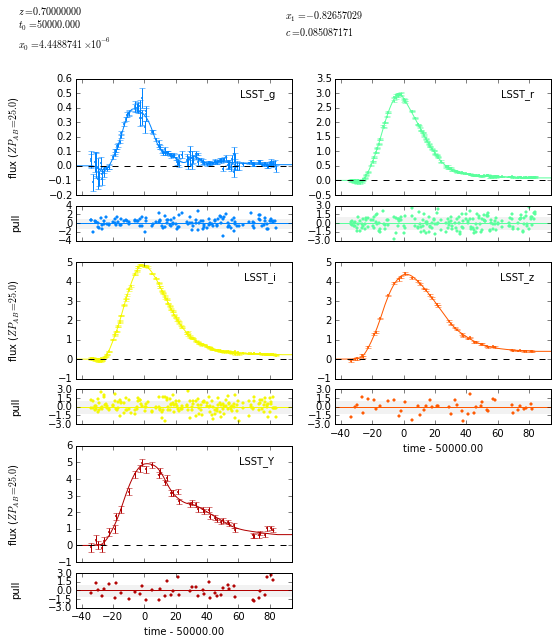

In [23]:
model.set(**params[0])
fig_relevant = sncosmo.plot_lc(relevantdata[0], model=model)

In [24]:
sncosmo.write_lc(Table(relevantdata[0]), fname='lc.dat', format='ascii')

In [25]:
lc = sncosmo.read_lc('lc.dat', format='ascii')

In [26]:
fmodel = sncosmo.Model(source='salt2-extended')
fmodel.set(z=0.7)
res, fitmodel = sncosmo.fit_lc(lc, fmodel, ['t0', 'x0', 'x1', 'c']) 

In [27]:
print res

       errors: OrderedDict([('t0', 0.014674440946691902), ('x0', 6.154772695644311e-09), ('x1', 0.011397626839770714), ('c', 0.0015473856551365055)])
   parameters: array([  7.00000000e-01,   4.99999936e+04,   4.44768430e-06,
        -8.20567663e-01,   8.37436300e-02])
      success: True
         ndof: 614
   covariance: array([[  2.15339218e-04,  -2.49707474e-11,   4.03696062e-05,
         -1.25232160e-07],
       [ -2.49707474e-11,   3.78812269e-17,  -4.90963511e-11,
          2.16263456e-13],
       [  4.03696062e-05,  -4.90963511e-11,   1.29905898e-04,
          5.60668717e-06],
       [ -1.25232160e-07,   2.16263456e-13,   5.60668717e-06,
          2.39440237e-06]])
 vparam_names: ['t0', 'x0', 'x1', 'c']
        chisq: 631.1774940446252
  param_names: ['z', 't0', 'x0', 'x1', 'c']
      message: 'Minimization exited successfully.'
        ncall: 119


In [28]:
fmodel.set(z=0.7)
res, fittedmodel = sncosmo.fit_lc(relevantdata[0], fmodel, ['t0', 'x0', 'x1', 'c'])

The true values of the model parameters can be found from the metadata of the light curves

In [30]:
relevantdata[0].meta

{'c': 0.08508717063831228,
 't0': 50000.0,
 'x0': 4.4488741295730986e-06,
 'x1': -0.8265702900771488,
 'z': 0.7}

In [29]:
print res

       errors: OrderedDict([('t0', 0.014674441128590843), ('x0', 6.154772651810737e-09), ('x1', 0.011397626767608252), ('c', 0.0015473856539616573)])
   parameters: array([  7.00000000e-01,   4.99999936e+04,   4.44768430e-06,
        -8.20567663e-01,   8.37436300e-02])
      success: True
         ndof: 614
   covariance: array([[  2.15339224e-04,  -2.49707479e-11,   4.03696064e-05,
         -1.25232223e-07],
       [ -2.49707479e-11,   3.78812264e-17,  -4.90963502e-11,
          2.16263418e-13],
       [  4.03696064e-05,  -4.90963502e-11,   1.29905896e-04,
          5.60668719e-06],
       [ -1.25232223e-07,   2.16263418e-13,   5.60668719e-06,
          2.39440236e-06]])
 vparam_names: ['t0', 'x0', 'x1', 'c']
        chisq: 631.1774940422397
  param_names: ['z', 't0', 'x0', 'x1', 'c']
      message: 'Minimization exited successfully.'
        ncall: 119
